<center>
    COMP4600/5500 - Reinforcement Learning

# Homework 3 - Dynamic Programming

### Due: Monday, October 4th 11:59 pm
    
</center>

Student Name: Mohamed Martini

The purpose of this project is to study different properties of dynamic programming methods. 

In [1]:
# You are allowed to use the following modules
import numpy as np
import matplotlib.pyplot as plt


In [2]:
class QLearner:
    """
    base class for a Q learner class with value iteration method
    child classes shall only provide their custom dynamics
    """
    def __init__(self, 
                 S,  # set of states
                 A,  # set of actions
                 gamma):  # discount parameter
        self.S = S
        self.num_states = S.shape[0]

        self.A = A
        self.num_actions = A.shape[0]
        
        self.gamma = gamma
        
        self.V = np.zeros(self.num_states)  # 9 states
        self.Q = np.zeros((self.num_actions, self.num_states))  # 9 states and two actions per state
        self.Pi = np.zeros(self.num_states)
    
    def dynamic_a(self, s):
        """return possible actions and their probabilities given a state s"""
        return None

    def dynamic_s_pr(self, s, a):
        """return possible states and their probabilities given state s and action a"""
        return None

    def dynamic_r(self, s, a, s_pr):
        """return possible rewards and their probabilities given state s and action a and next state s_pr"""
        return None

    def v_iteration_thresh(self, thresh):
        """value iteration algorithm by threshold"""
        k = 0
        while True:
            k += 1
            delta = 0
            for s in range(self.num_states):
                A = self.dynamic_a(s)
                for a in np.where(A>0)[0]:
                    
                    q_as = 0
                    S_pr = self.dynamic_s_pr(s, a)
                    for s_p in np.where(S_pr>0)[0]:
                        p_s_p = S_pr[s_p]
                        
                        R = self.dynamic_r(s, a, s_p)
                        for r in np.where(R>0)[0]:
                            p_r = R[r]
                            
                            q_as += p_s_p * p_r * (r + self.gamma * self.V[s_p])
                            
                    self.Q[a, s] = q_as
                old = self.V[s]
                self.V[s] = max(self.Q[:, s])
                self.Pi[s] = np.argmax(np.round(self.Q[:, s], 10))
                delta = max(delta, self.V[s] - old)
            if delta < thresh:
                break
        return self.V, self.Pi, k

    def v_iteration_k(self, k=50):
        """value iteration algorithm by k iterations"""
        for _ in range(k):
            for s in range(self.num_states):
                A = self.dynamic_a(s)
                for a in np.where(A>0)[0]:
                    q_as = 0
                    S_pr = self.dynamic_s_pr(s, a)
                    for s_p in np.where(S_pr>0)[0]:
                        p_s_p = S_pr[s_p]
                        R = self.dynamic_r(s, a, s_p)
                        for r in np.where(R>0)[0]:
                            p_r = R[r]
                            q_as += p_s_p * p_r * (r + self.gamma * self.V[s_p])
                    
                    self.Q[a, s] = q_as

                old = self.V[s]
                self.V[s] = max(self.Q[:, s])
                self.Pi[s] = np.argmax(np.round(self.Q[:, s], 10))
        return self.V, self.Pi

In [3]:
def print_1d(array, name):
    """to print a 1d array"""
    print("{} = (".format(name))
    [print(round(n,2), end=",\t") for n in array]
    print("\n)\n")


## Part I
Consider a cleaning robot that must collect an empty can and also has to recharge its batteries.
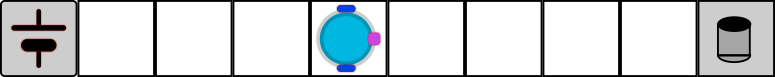

This problem has a discrete state space $S=\{0,…,9\}$, where state $s$ describes the position of the robot in the corridor. The robot has only two actions $A=\{-1,1\}$ for going one step to the left or right. States $0$ and $9$ are terminal, meaning that once the robot reaches either of them it can no longer leave, regardless of the action, and the episode ends. We assume this is a deterministic environment with $\gamma=0.9$.



In [4]:
class CleaningRobot(QLearner):
    """Q learner class for problem 1"""
    def __init__(self, 
                 S,  # set of states
                 A,  # set of actions
                 gamma):  # discount parameter
        super(CleaningRobot, self).__init__(S, A, gamma)

    def dynamic_a(self, s):
        """get available actions in state s"""
        if s in (0, 9):
            # no action is taken
            return np.zeros(self.num_actions)
        return np.array([0.5, 0.5])

    def dynamic_s_pr(self, s, a):
        """state-transition function"""
        if s in (0, 9):
            # no action is taken
            return np.zeros(self.num_states)
        S_pr = np.zeros(self.num_states)
        S_pr[s + self.A[a]] = 1
        return S_pr

    def dynamic_r(self, s, a, s_pr):
        """reward function"""
        R = np.zeros(6)
        if s == 8 and a == 1:
            R[5] = 1
        elif s == 1 and a == 0:
            R[1] = 1
        else: R[0] = 1
        return R


In [5]:
S = np.array(range(10))
A = np.array((-1, 1), dtype=int)
gamma = 0.9

cr = CleaningRobot(S, A, gamma)
V, Pi_star, _ = cr.v_iteration_thresh(thresh=0.01)

print_1d(V, "V*")
print_1d(Pi_star, "\u03C0*")


V* = (
0.0,	2.39,	2.66,	2.95,	3.28,	3.64,	4.05,	4.5,	5.0,	0.0,	
)

π* = (
0.0,	1.0,	1.0,	1.0,	1.0,	1.0,	1.0,	1.0,	1.0,	0.0,	
)






<hr>

## Part II (*)
A gambler has the opportunity to make bets on the outcomes of a sequence of coin flips. If the coin comes up heads, he wins as many dollars as he has staked on that flip; if it is tails, he loses his stake. The game ends when the gambler wins by reaching his goal of \$100, or loses by running out of money. 

On each flip, the gambler must decide what portion of his capital to stake, in integer numbers of dollars. This problem can be formulated as an **undiscounted** ($\gamma=1$), **episodic**, finite MDP.

The state is the gambler’s capital $s \in \{ 1,2,...,99\}$ and the actions are stakes $a \in \{ 0,1,..., min(s, 100-s)\}$. The reward is zero on all transitions except those on which the gambler reaches his goal, when it is +1. 
The state-value function then gives the probability of winning from each state. 

A policy is mapping from levels of capital to stakes. The optimal policy maximizes the probability of reaching the goal. 
Let’s p_h denote the probability of the coin coming up heads. If $p_h$ is known the problem can be solved using value iteration.



### II.1
Implement the Gambler’s problem and then implement **value iteration** to solve the MDP for three scenarios where $p_h=\{0.4,0.25,0.55\}$ and find the optimal value function and optimal policy for each scenario.

**Tip**: When implementing, you might find it convenient to introduce two dummy states corresponding to termination with capital of 0 and 100, giving them values of 0 and 1 respectively.

In [6]:
class Gambler(QLearner):
    """Q learner class for problem 1"""
    def __init__(self, 
                 S,  # set of states
                 A,  # set of actions
                 gamma,  # discount parameter
                 p_h):  # probability of head
        super(Gambler, self).__init__(S, A, gamma)
        self.p_h = p_h

    def dynamic_a(self, s):
        A = np.zeros(self.num_actions)
        if s in (0, 100):
            return A
        """get available actions in state s"""
        biggest_bid = min(s, 100 - s)
        A[1 : biggest_bid + 1] = 1 / biggest_bid
        return A

    def dynamic_s_pr(self, s, a):
        """state-transition function"""
        S_pr = np.zeros(self.num_states)
        if s in (0, 100):
            S_pr[0] = 1
            return S_pr
        S_pr[s + a] = self.p_h  # agent wins
        S_pr[s - a] = 1 - self.p_h  # agent loses
        return S_pr

    def dynamic_r(self, s, a, s_pr):
        """reward function"""
        R = np.zeros(self.num_states)
        if s + a == 100 and s != 100:
            R[1] = 1
        else:
            R[0] = 1
        return R


### II.2
For all three scenarios:
1. Plot the change in the value function over successive sweeps of value iteration w.r.t capital (state).
2. Plot the final policy w.r.t capital (state). 



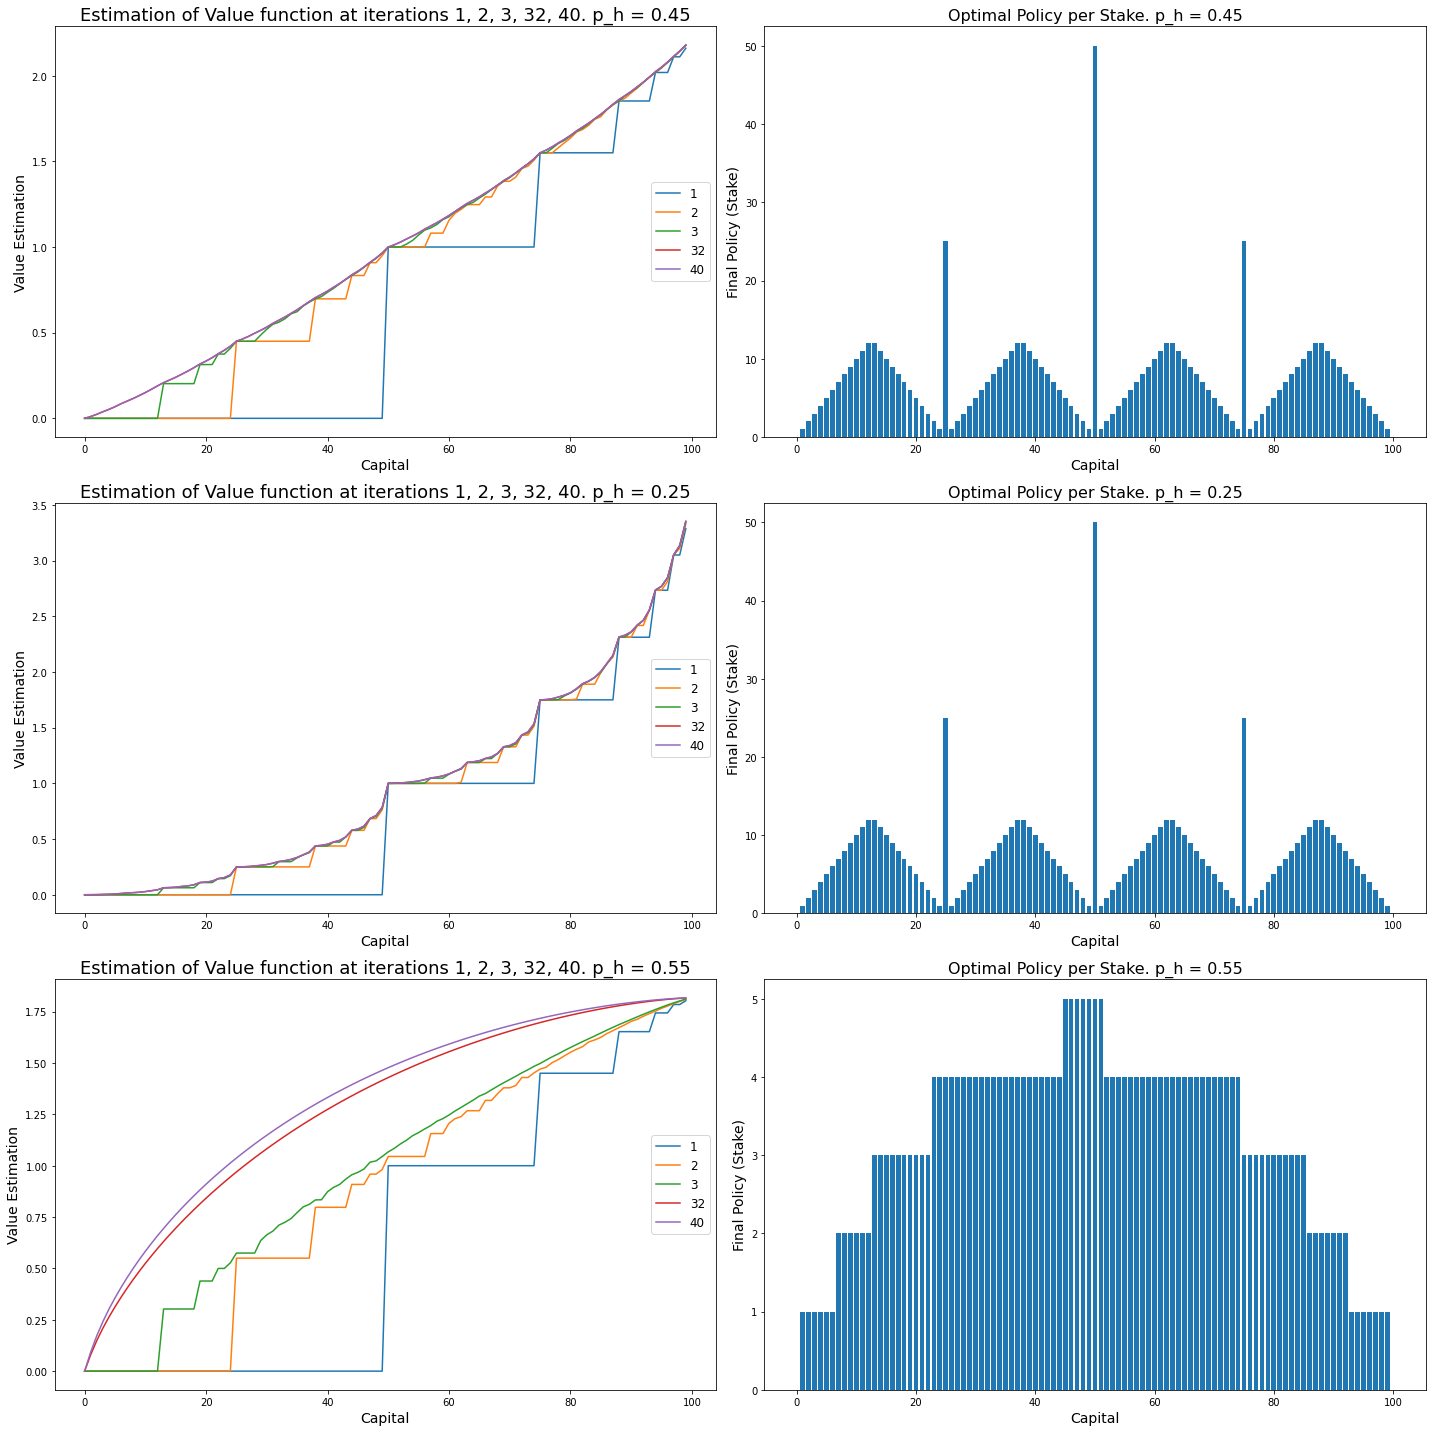

In [7]:
S = np.array(range(101))
A = np.array(range(101))
gamma = 1
k = 40
k_plot = [1, 2, 3, 32, k]
threshold = 1e-3

p_hs = [0.45, 0.25, 0.55]

fig, axes = plt.subplots(3, 2, figsize=(20,20))

for idx, p_h in enumerate(p_hs):
    gambler = Gambler(S, A, gamma, p_h)
    axes[idx, 0].set_title(
        f"Estimation of Value function at iterations {', '.join([str(k) for k in k_plot])}. p_h = {p_h}",
        size=18
    )
    axes[idx, 1].set_title(
        f"Optimal Policy per Stake. p_h = {p_h}",
        size=16
    )

    for i in range(1, k + 1):
        V, Pi_star = gambler.v_iteration_k(k=1)
        if i in k_plot:
            axes[idx, 0].plot(V[:-1], label=i)
    axes[idx, 0].set_xlabel('Capital', fontsize=14)
    axes[idx, 0].set_ylabel('Value Estimation', fontsize=14)
    axes[idx, 0].legend(loc='center right', fontsize="large")

    axes[idx, 1].bar(range(len(Pi_star)), Pi_star)
    axes[idx, 1].set_xlabel('Capital', fontsize=14)
    axes[idx, 1].set_ylabel('Final Policy (Stake)', fontsize=14)


fig.tight_layout() 
plt.show()


### II.3
Answer the following questions:
1. What action does your optimal policy suggest for capital of 50? What about for capital of 51?
> Answer: $\newline$
Capital 50: 50 $\newline$
Capital 51: 1

2. Why do you think your optimal policy is a good policy? Explain.
> Answer: $\newline$
When the probability of a head is less than 0.5, the gambler must win against the odds, and thus must gamble as few times as possible to win, because the more they gamble the more likely they'll lose their stake. This is achieved in the calculated policy: at any capital, the gambler stakes an amount such that if they win they end up with 25, 50, 75, or 100. At 100, the gambler wins, and at (25, 50, 75) the gambler is at (2, 1, 1) steps left to win.
When the probability of a head is more than 0.5, the gambler is more likely to win a bet, and is thus encouraged to play safe to win.  
    


## Part III (extra credit)
Test the algorithm by decreasing $\theta$ the threshold for accuracy of value function estimation. What happens when $\theta \rightarrow 0$? You can add any helpful code/graphs if you have.

> Answer $\newline$
It seems that the accuracy of the value estimation function increases with lower threashold "$\theta$" values. This is because decreasing the threshold increases the number of iterations necessary for the value function to converge. Interistingly, different $p_h$ values require different numbers of iterations to converge to the same accuracy, as shown in the plot below.

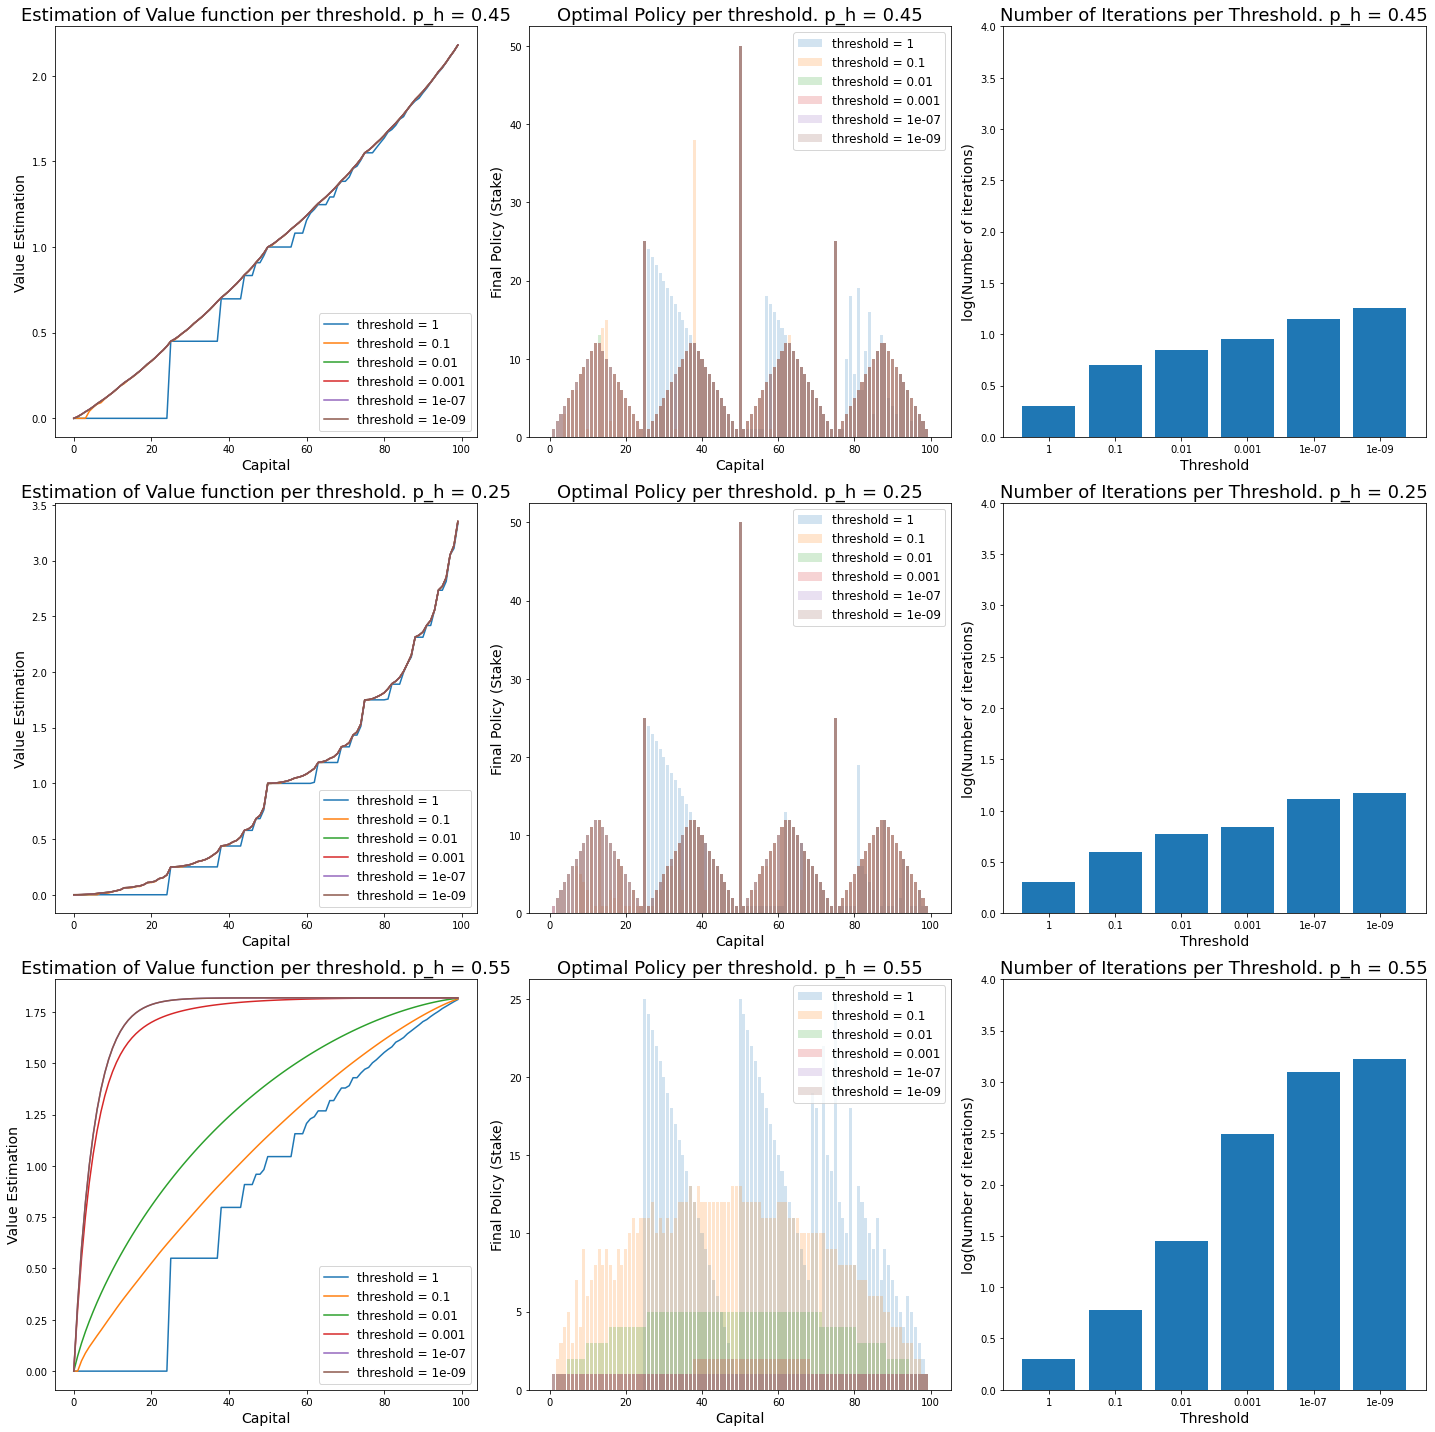

In [8]:
S = np.array(range(101))
A = np.array(range(101))
gamma = 1
thresholds = [1, 1e-1, 1e-2, 1e-3, 1e-7, 1e-9]
p_hs = [0.45, 0.25, 0.55]

fig, axes = plt.subplots(len(p_hs), 3, figsize=(20,20))

for row, p_h in enumerate(p_hs):
    axes[row, 0].set_title(
        f"Estimation of Value function per threshold. p_h = {p_h}",
        size=18
    )
    axes[row, 0].set_xlabel('Capital', fontsize=14)
    axes[row, 0].set_ylabel('Value Estimation', fontsize=14)

    axes[row, 1].set_title(
        f"Optimal Policy per threshold. p_h = {p_h}",
        size=18
    )
    axes[row, 1].set_xlabel('Capital', fontsize=14)
    axes[row, 1].set_ylabel('Final Policy (Stake)', fontsize=14)


    axes[row, 2].set_title(
        f"Number of Iterations per Threshold. p_h = {p_h}",
        size=18
    )
    axes[row, 2].set_xlabel('Threshold', fontsize=14)
    axes[row, 2].set_ylabel('log(Number of iterations)', fontsize=14)

    K = []
    for threshold in thresholds:
        gambler = Gambler(S, A, gamma, p_h)
        V, Pi_star, k = gambler.v_iteration_thresh(thresh=threshold)

        axes[row, 0].plot(V[:-1], label=f"{threshold =: }")
        axes[row, 1].bar(range(len(Pi_star)), Pi_star, label=f"{threshold =: }", alpha=0.2)
        K.append(k)

    axes[row, 2].bar([str(t) for t in thresholds], np.log10(K))
    axes[row, 2].set_ylim(0, 4)

    axes[row, 0].legend(loc='lower right', fontsize="large")
    axes[row, 1].legend(loc='upper right', fontsize="large")

fig.tight_layout()    
plt.show()
